In [1]:
from functions import sample_uniform_parameters, sample_correlated_parameters, output_from_parameters, output_from_parameters_with_noise, obtain_theta, perform_CNLS_LASSO, obtain_beta_unique, add_random_variables
from pystoned.plot import plot2d
import numpy as np
import pandas as pd

### Sample the true parameters X (iid vs. Correlated), and create Y
### Obtain theta from the results

In [2]:
# Correlations between variables. rho12 is the correlation between x1 and x2, rho13 is the correlation between x1 and x3, etc.
# When adding more correlations, make sure to add them to the list corrs as well in the correct order. 
# That is, rho12, rho13, rho23, rho14, rho24, rho34, rho15, rho25, rho35, rho45, rho16, rho26, rho36, rho46, rho56
rho12 = 0.6
rho13 = 0.2
rho23 = 0.5
rho14 = 0.6
rho24 = 0.1
rho34 = 0.6
rho15 = 0.4
rho25 = 0.6
rho35 = 0.2
rho45 = 0.8

corrs = [rho12, rho13, rho23, rho14, rho24, rho34, rho15, rho25, rho35, rho45]

In [7]:
x = sample_correlated_parameters(5,9, corrs, min_value=10, max_value=20, seed=2)
x

,0,1,2,3,4,5,6,7,8
0,10.580836,16.499026,24.003918,29.560969,30.824673,16.011150,17.319939,18.661761,19.507143
1,10.205845,16.336825,23.030712,28.977046,30.357534,15.247564,17.080726,18.324426,19.699099
2,11.394939,16.416630,23.509545,29.264346,30.587374,14.319450,14.560700,16.118529,17.851760
3,10.464504,16.638720,24.842084,30.063869,31.226992,16.075449,18.083973,19.488855,19.656320
4,10.343885,16.383266,23.309357,29.144233,30.491284,14.401525,14.951769,16.842330,19.093204


In [8]:
# x = sample_uniform_parameters(2,25, min_value=1, max_value=50, seed=2)
y_log_true = output_from_parameters(x, cons = 3)
y_log = output_from_parameters_with_noise(x, cons=3, var=0.1)
x = add_random_variables(x, 7, min_value = 30, max_value = 40, seed=3)

In [9]:
theta = obtain_theta(x, y_log_true)

### Perform the SCNLS-LASSO regression

In [11]:
model_cnls = perform_CNLS_LASSO(x=x, y=y_log_true, eta=0.2)
beta = model_cnls.get_beta()
alpha = model_cnls.get_alpha()
beta = pd.DataFrame(beta).round(3)
beta.loc['Total',:] = beta.sum(axis=0)
display(beta)
# beta_unique = obtain_beta_unique(x, alpha, beta).T.round(2).rename(columns={0:'Alpha'})
# beta_unique.loc['Total',:] = beta_unique.sum(axis=0)
# display(beta_unique)
# plot2d(model_cnls, x_select=0, label_name="CNLS", fig_name='CNLS_frontier')

Estimating the additive model remotely with mosek solver.


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.000,0.000,0.057,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0
1,0.0,0.000,0.000,0.036,0.000,0.0,0.0,0.0,0.001,0.0,0.0,0.0
2,0.0,0.031,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0
3,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0
4,-0.0,-0.000,-0.000,-0.000,-0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0
5,0.0,0.002,0.000,0.020,0.017,0.0,0.0,0.0,0.000,0.0,0.0,0.0
6,0.0,0.000,0.032,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0
7,0.0,0.000,0.032,0.000,0.000,-0.0,0.0,0.0,0.000,0.0,0.0,0.0
8,0.0,0.000,0.032,0.000,0.000,-0.0,0.0,-0.0,-0.000,0.0,-0.0,0.0
Total,0.0,0.033,0.096,0.113,0.017,0.0,0.0,0.0,0.001,0.0,0.0,0.0


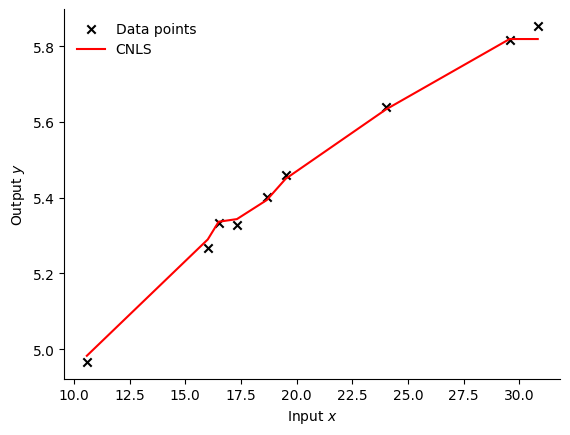

In [12]:
plot2d(model_cnls, x_select=0, label_name="CNLS", fig_name='CNLS_frontier')